<h1> Analytic SGWB generator</h1> 

In the following, we'll implement a notebook that, given a certain volume of sky and some parameters describing a BH population, return the value of the predicted analytical SGWB
The probability distribution implemented for the variables of the events, will be taken from [B. P. Abbott T1](https://arxiv.org/abs/1811.12940), [B. P. Abbott T2](https://arxiv.org/abs/2010.14533).
First of all, we need to import some modules ! 

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import pandas as pd
import multiprocessing as mp
import scipy.stats as scst
from scipy import interpolate
from scipy.integrate import quad
from scipy.stats import poisson
from multiprocessing import Pool, Manager, Value
from functools import partial
from LISAhdf5 import LISAhdf5,ParsUnits
#%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

<h2> Global Variables of the Simulation </h2>

The global variables of the simulation will be set to :

In [2]:
# Flags for the execution modes, initialized to false, check the the FLAG selection section for additional informations and initializing them !

SOBBH = False
SOBBH_Redevol = False

# Merger distribution parameters

T_obs = 6. # Lisa estimated years of observation
efficiency = 0.75 # Lisa effective usefull time percentage for observations
max_tc = 10000. # max years of coalescence time for a BBH mergine event
frq_min = 3.e-5
frq_max = 0.5 # Maximum frequency in hertz to which the LISA detector is sensitive
frq_res = 1.e-5 

# The total time used to generate the merging events by multipling for the rate of merging will be set to max_tc


#General Constants 

c = 299792.46 # speed of light in Km/sec
G = 6.674*(10.**(-11.)) # Gravitational constant in m^3⋅kg^−1⋅s^−2
sol_mass = 1.988e30 # Value of the Solar Mass in Kg
h = 0.678
H_0 = 67.8/(3.086e+19) # Hubble constant in 1/(s)
Omega_m = 0.3 # Matter density in our universe
Omega_lambda = 0.7 # Cosmological constant density in our universe
Omega_k = 0. # Curvature density in our universe
rho_c = (3.*(H_0**2.))/(8.*np.pi*G) # Critical density in our universe
year = 365.25*24*60*60 # Years in second 
    
# Precision settings for the binned variables

n_jobs = 12
frq_prec = int((frq_max - frq_min)/frq_res) + 1

# Variable specific for the SOBBH case
SOBBH_massprec = 600           # Binning density for the masses
SOBBH_zprec = 600              # Binning density for the redshift (affect distance density)

<h2> FLAG selection section </h2>

To begin, we have to decide which types of sources we wish to simulate in our SGWB :

In [3]:
SOBBH = True # If true, add the SGWB strain produced by stellar origin binary black hole merging on the strain

We may also decide to simulate the catalogue with a redshift evolving merging rate, by setting to true the Red_evol flag:

In [4]:
SOBBH_Redevol = True # If true, the merging rate will evolve as a function of redshift, if false it will be assumed constant over the volume

<h2> Standard Cosmological Functions </h2>

First of all, we'll need a function that allow us to convert from redshift to Gigaparsec :

In [5]:
# Just a function to convert from Z to GPC using Hubble Law, in order to obtain the comoving distance

def H(z):
    return np.sqrt((H_0**2.)*(Omega_m*((1. + z)**3.) + Omega_k*((1. + z)**2.) + Omega_lambda))

def Z_to_Gpc(z):
    
    # Remove the commented part to use a linear approximation of the Hubble law for low z 
    
    #if(zmax <= 0.5):
    #    return ((z*c*(10**(-3)))/(H_0)) # only valid for z < 0.5
    #else:
        
        Int_Z = 0.
        span_z = np.linspace(0.,z,z_prec)
        
        # Beware, would fail if the span z is created in logarithmic scale !
        
        for i in range(len(span_z) -1):
            mid_z = 0.5*(span_z[i] + span_z[i + 1])
            Int_Z += (((span_z[i + 1] -  span_z[i])*c*(10**(-3)))/(H(mid_z)))
    
        return Int_Z
    
        

we also need a function that estimates the differential comoving volume in function of the redshift :

In [6]:
#In the following function, the differential comoving volume in function of the redshift will be estimated as a spherical surface, it need to be integrated over dr to obtain the real volume 

def DeVC(z, Delta_z):
    r = Z_to_Gpc(z)
    z_2 = z + 0.5*Delta_z
    z_1 = z_2 - Delta_z
    Delta_r = Z_to_Gpc(z_2) - Z_to_Gpc(z_1)
    return ((4.*np.pi*(r**2.)*Delta_r)/Delta_z)

Another recurring parameter for inspiralling events is the Chirp Mass, given the mass of the two events involved in the binary merging :

In [7]:
# Function that return the Chirp Mass of a binary merging event

def ChirpMass(m1,m2): 
   return ((m1*m2)**(3./5.))/((m1+m2)**(1./5.))

and indeed we are gonna need to convert our strain from units of _h_ or _hc_ to units of omega :

In [8]:
def h_to_Omega(ran_frq, spectrum):
    # ran_frq and spectrum need to have same shape
    return ((4*((h*np.pi)**2.)*(ran_frq**3.)*spectrum)/(3.*(H_0**2)))

In [9]:
def hc_to_Omega(ran_frq, spectrum):
    # ran_frq and spectrum need to have same shape
    return ((2*((h*np.pi)**2.)*(ran_frq**2.)*spectrum)/(3.*(H_0**2)))

<h2> LISA sensitivity curve </h2>

In the following we are going to generate the LISA sensitivity curve, in order to compare our result with the properties of the instrument.
The shape of the sensitivity curve in units of S can be defined using the following function :

In [10]:
# return the value of the sensitivity curve S_h given the frequency

def get_SciRD(freq):
    S_2 = 3.6*10.**(-41.) #1/Hz
    S_1 = 5.76*(1. + (0.0004/freq)**2.)*10.**(-48.) # 1/(Hz*s^4)
    S_R = 1. + (freq/0.025)**2.
    S_h = (10./3.)*S_R*((S_1/(2.*np.pi*freq)**4.) + S_2)
    return S_h

<h2> SOBBH SGWB </h2>

In this section, we are going to initialize all the objects needed to compute the Stellar Origin Binary Black Hole merging SGWB.

<h3> SOBBH - Characteristic strain functions </h3>

The characteristic strain is given by :

In [11]:
# Function to estimate the characteristic strain for SOBBHm events

if SOBBH :
    def SOBBH_hcsqrd(frq, SOBBH_IntFac):
        return ((4.*G**(5./3.))/(3.*(np.pi**(1./3.))*(c*10**3)**2))*(frq**(-4./3.))*SOBBH_IntFac
            

<h3> SOBBH - Mass distribution functions </h3>

Let's start by defining the probability distribution in function of the masses.

We have :

In [12]:
# Power law + Peak Mass Model of the paper arxiv 2010.14533

# Mass Distribution parameters (values taken from the results of arxiv arxiv 2111.03634)

if SOBBH :
    SOBBH_m = 2.5 # + 0.67 - 0.44 Solar Masses 
    SOBBH_M = 100. # Solar Masses 
    SOBBH_alpha = 3.4 # + 0.58 - 0.49 PL spectral index
    SOBBH_betaq = 1.1 # + 1.8 - 1.3 index for m2 power law in q
    SOBBH_deltam = 7.8 #+ 1.9 - 4.0  used for the low mass smoothing function, generate peak at delta_m + m_min 
    SOBBH_lambdapeak = 0.039 # + 0.058 - 0.026 Intensity of the gaussian peak
    SOBBH_mum = 34 # + 2.3 - 3.8 Location of the Gaussian peak in Solar Masses
    SOBBH_sigmam = 5.09 # +4.28 - 4.34 Solar Masses

    # Defining of the smoothing function for m close to the minimimum mass

    def SOBBH_MassSmoothing(m, SOBBH_m, SOBBH_deltam):
        if(m < SOBBH_m):
            return 0.
        else:
            if(m >= (SOBBH_m + SOBBH_deltam)):
                return 1.
            else:
                factor = np.exp((SOBBH_deltam/(m - SOBBH_m)) + (SOBBH_deltam/(m - SOBBH_m - SOBBH_deltam)))
                return 1./(factor + 1.)

    # Defining a normalized power law distribution function, needed for the final distribution function        

    def SOBBH_MassPowLaw(m, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_PLnorm):
        if(SOBBH_m < m < SOBBH_M):
            return (1./SOBBH_PLnorm)*(m**(-SOBBH_alpha))
        else:
            return 0.

    # Estimating the Phase space of the Power law distribution using trapezoidal integration

    def SOBBH_PowerLawPS(SOBBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_alpha):

        ris = 0.

        for i in range(len(SOBBH_ranm1)- 1):
           if(SOBBH_ranm1[i] >= SOBBH_m and SOBBH_ranm1[i] <= SOBBH_M):
                    mid_m1 = 0.5*(SOBBH_ranm1[i + 1] + SOBBH_ranm1[i])
                    ris +=  (SOBBH_ranm1[i + 1] - SOBBH_ranm1[i])*(np.power(mid_m1, (-SOBBH_alpha)))

        return ris


    # Defining a Gaussian distribution of the mass, needed for the final distribution function

    def SOBBH_MassGauss(m, SOBBH_mum, SOBBH_sigmam, SOBBH_GSnorm):
        return ((1./(SOBBH_sigmam*np.sqrt(2.*np.pi)))*np.exp(-0.5*((m-SOBBH_mum)/SOBBH_sigmam)**2.))*1./SOBBH_GSnorm

    def SOBBH_GaussPS(SOBBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_mum, SOBBH_sigmam):

        ris = 0.

        for i in range(len(SOBBH_ranm1)- 1):
           if(SOBBH_ranm1[i] >= SOBBH_m and SOBBH_ranm1[i] <= SOBBH_M):
                    mid_m1 = 0.5*(SOBBH_ranm1[i + 1] + SOBBH_ranm1[i])
                    ris +=  (SOBBH_ranm1[i + 1] - SOBBH_ranm1[i])*((1./(SOBBH_sigmam*np.sqrt(2.*np.pi)))\
                            *np.exp(-0.5*((mid_m1-SOBBH_mum)/SOBBH_sigmam)**2.))

        return ris


    # Defining the normalization constant for the q dependancy of the total mass distribution

    def SOBBH_P2PS(SOBBH_ranm2, SOBBH_betaq, SOBBH_m, SOBBH_deltam):

        q_norm = np.linspace(0,1,len(SOBBH_ranm2))

        for i in range(len(SOBBH_ranm1) - 1):

            q_norm[i] = 0.

            for j in range(i + 1):

                q_norm[i] += ((0.5*(SOBBH_ranm2[j] + SOBBH_ranm2[j + 1])/(0.5*(SOBBH_ranm2[i] + SOBBH_ranm2[i + 1])))\
                             **(SOBBH_betaq))*(SOBBH_ranm2[j + 1] - SOBBH_ranm2[j])*\
                             SOBBH_MassSmoothing(0.5*(SOBBH_ranm2[j] + SOBBH_ranm2[j + 1]), SOBBH_m, SOBBH_deltam)

        q_norm[len(SOBBH_ranm1) - 1] = q_norm[len(SOBBH_ranm1) - 2]

        return q_norm   


    # Defining the proper Mass distribution function

    def SOBBH_MassDistr(m1, m2, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_betaq, SOBBH_deltam, SOBBH_lambdapeak, SOBBH_mum, SOBBH_sigmam, SOBBH_PLnorm, SOBBH_GSnorm, SOBBH_qnorm, SOBBH_MassPS):

        if(m1 > m2):
            return ((1. - SOBBH_lambdapeak)*SOBBH_MassPowLaw(m1, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_PLnorm) + \
                    SOBBH_lambdapeak*SOBBH_MassGauss(m1, SOBBH_mum, SOBBH_sigmam, SOBBH_GSnorm))*\
                    SOBBH_MassSmoothing(m1, SOBBH_m, SOBBH_deltam)*\
                    ((m2/m1)**(SOBBH_betaq))*(1./SOBBH_qnorm)*\
                    SOBBH_MassSmoothing(m2, SOBBH_m, SOBBH_deltam)*(1./SOBBH_MassPS)
        else:
            return 0.


    # Estimating the Phase space for the Model C Mass distribution function using trapezoidal integration

    def SOBBH_ModCPS(SOBBH_ranm1, SOBBH_ranm2, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_betaq, SOBBH_deltam, SOBBH_lambdapeak, SOBBH_mum, SOBBH_sigmam, SOBBH_PLnorm, SOBBH_GSnorm, SOBBH_qnorm, SOBBH_MassPS):

        ris = 0.

        for i in range(len(SOBBH_ranm1)- 1):
            for j in range(len(SOBBH_ranm2)- 1):
                 if(SOBBH_ranm1[i] >= SOBBH_ranm2[j]):
                    mid_m1 = 0.5*(SOBBH_ranm1[i + 1] + SOBBH_ranm1[i])
                    mid_m2 = 0.5*(SOBBH_ranm2[j + 1] + SOBBH_ranm2[j])
                    q = mid_m2/mid_m1 
                    ris +=  (SOBBH_ranm1[i + 1] - SOBBH_ranm1[i])*(SOBBH_ranm2[j + 1] - SOBBH_ranm2[j])*\
                    ((1. - SOBBH_lambdapeak)*SOBBH_MassPowLaw(mid_m1, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_PLnorm)\
                    + SOBBH_lambdapeak*SOBBH_MassGauss(mid_m1, SOBBH_mum, SOBBH_sigmam, SOBBH_GSnorm))\
                    *SOBBH_MassSmoothing(mid_m1, SOBBH_m, SOBBH_deltam)*(q**(SOBBH_betaq))\
                    *(1./SOBBH_qnorm[i])*SOBBH_MassSmoothing(mid_m2, SOBBH_m, SOBBH_deltam)*(1./SOBBH_MassPS)

        return ris
    

<h3> SOBBH - Redshift dependent statistic </h3>

We may now define, the merging rate as a function of the redshift _z_ as :

In [13]:
# Constant merging rate throughout the volume as fitted in the paper arxiv 1811.12940

#def R(z):
#    return 53.2 # +58.5 - 27.0 Gpc^-3 yr-1 Merger rate density assumed constant over the comoving volume

In [14]:
# Function for the merging rate as described in the paper arxiv 2010.14533, the flag Red_evol will decide if adopting a merging rate the evolve with redshift (true) or not (false)

if SOBBH :
    
    SOBBH_z = 1.e-5 # to avoid SNR divergence due to extremely close events
    SOBBH_Zlog = 0.1 # max z value generated in log scale
    SOBBH_Zlin = 10.0 # max z value generated in lin scale

    SOBBH_k = 2.7 # + 1.8 - 1.9  VALID FOR REDSHIFT EVOLVING POWER LAW + PEAK MODEL MASS DISTRIBUTION, total agreement with SFR
    SOBBH_CorrRz = (((1. + 0.2)**SOBBH_k)/(1. + ((1. + 0.2)/2.9)**(SOBBH_k + 2.9)))**(-1) # Normalization factor estimated at z = 0.2
    
    # Defining the value of R0, the 0 index will have the value for redshift evolution merging rate, the 1 index would have the one for constant merging rate

    SOBBH_R0 = {}
    SOBBH_R0[0] = 28.1/(year*(3.086e+25)**3.)# +14.8 - 10.0 GPC⁻³ yr^⁻¹ Value of the merging rate fitted at z = 0.2
    SOBBH_R0[1] = 23.9/(year*(3.086e+25)**3.) # +14.9 - 8.6 m^-3 s^-1 Middle value fitted using a Power Law + Peak mass model and a non evolving merging rate

    def SOBBH_R(z):
        if(SOBBH_Redevol):
            # This merging rate was interpolated by Angelo Ricciardone and Daniel Figueroa based on arxiv 2010.14533 and arxiv 1907.12562
            return SOBBH_R0[0]*SOBBH_CorrRz*((1. + z)**SOBBH_k)/(1. + ((1. + z)/2.9)**(SOBBH_k + 2.9))
        else:
            return SOBBH_R0[1]        


<h3> SOBBH - Number density of events</h3>

We may finally define the distribution function for the number of events,in particular let's start with the function that describes the merging rate dependancy on the reference frame time: 

In [15]:
if SOBBH:
    def SOBBH_DtrDz(z):
        ris = 1./(H_0*(1. + z)*np.sqrt(Omega_m*((1. + z)**3.) + Omega_k*((1. + z)**2.) + Omega_lambda))
        return ris
        

we can now integrate the mass and redshift dependant factor in order to get a constant that will multiply the frequency dependance of the characteristic strain function.
After putting together all the integral dependant factors, we just have to integrate :

In [16]:
if SOBBH :
    def SOBBH_IntND(i):
        
        ris = 0.
        
        if ((i*10)%len(SOBBH_ranz) == 0) :
            print('Percentage of completition : ',(i*100.)/(len(SOBBH_ranz)), '%')
                
        for j in range(len(SOBBH_ranm1)-1):
            for k in range(j + 1):
                deltas = (SOBBH_ranz[i + 1] - SOBBH_ranz[i])*(SOBBH_ranm1[j + 1] - SOBBH_ranm1[j])*(SOBBH_ranm2[k + 1] - SOBBH_ranm2[k])
                ris += deltas*SOBBH_R(0.5*(SOBBH_ranz[i + 1] + SOBBH_ranz[i]))*\
                            SOBBH_MassDistr(0.5*(SOBBH_ranm1[j + 1] + SOBBH_ranm1[j]), 0.5*(SOBBH_ranm2[k + 1] + SOBBH_ranm2[k]),\
                                           SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_betaq, SOBBH_deltam, \
                                           SOBBH_lambdapeak, SOBBH_mum, SOBBH_sigmam, SOBBH_PLnorm, SOBBH_GSnorm, \
                                           SOBBH_qnorm[j], SOBBH_MassPS)*\
                            SOBBH_DtrDz(0.5*(SOBBH_ranz[i + 1] + SOBBH_ranz[i]))*\
                            ((ChirpMass(0.5*(SOBBH_ranm1[j + 1] + SOBBH_ranm1[j]),\
                                        0.5*(SOBBH_ranm2[k + 1] + SOBBH_ranm2[k]))*sol_mass)**(5./3.))\
                            /((1. + 0.5*(SOBBH_ranz[i + 1] + SOBBH_ranz[i]))**(1./3.)) 
                        
        return ris
                               
                        

<h2> Setting of the analyzed phase space </h2>

The simulation will be spanned over the following range of variables :

In [17]:
# Inizialization of the frequency range and spectrum

ran_frq = np.linspace(frq_min, frq_max, frq_prec)
sensitivity = get_SciRD(ran_frq)
spectrum = ran_frq * 0.

# Initialization of the mass phase space

if SOBBH:
    SOBBH_ranm1 = np.logspace(np.log10(SOBBH_m),np.log10(SOBBH_m + 5. - (SOBBH_M - (SOBBH_m + 5))/SOBBH_massprec), int(SOBBH_massprec/10))
    SOBBH_ranm1 = np.append(SOBBH_ranm1, np.linspace(SOBBH_m + 5., SOBBH_M,SOBBH_massprec))
    SOBBH_ranm2 = SOBBH_ranm1
    SOBBH_PLnorm = SOBBH_PowerLawPS(SOBBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_alpha)
    SOBBH_GSnorm = SOBBH_GaussPS(SOBBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_mum, SOBBH_sigmam) 
    SOBBH_qnorm = SOBBH_P2PS(SOBBH_ranm2, SOBBH_betaq, SOBBH_m, SOBBH_deltam)
    SOBBH_MassPS = SOBBH_ModCPS(SOBBH_ranm1, SOBBH_ranm2, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_betaq, SOBBH_deltam, SOBBH_lambdapeak, SOBBH_mum, SOBBH_sigmam, SOBBH_PLnorm, SOBBH_GSnorm, SOBBH_qnorm, 1.)

# Initialization of the distance phase space, we will use a logarithmic scale up to z = 1 and a linear from 1 to z_max

if SOBBH:
    SOBBH_ranz = np.logspace(np.log10(SOBBH_z), np.log10(SOBBH_Zlog), int(SOBBH_zprec/10))
    SOBBH_ranz = np.append(SOBBH_ranz, np.linspace(SOBBH_Zlog + (SOBBH_ranz[int(SOBBH_zprec/10)-1] - SOBBH_ranz[int(SOBBH_zprec/10)-2]), SOBBH_Zlin, SOBBH_zprec))

<h2> Main body of the simulation </h2>

We may finally launch the pipeline to generate SGWB spectrum on every frequency bin of the frequency range. 
First of all we need to estimate the integrated factors given the simulation parameters :

In [18]:
if SOBBH :
    
    # Summing the SOBBH background contribution
    if __name__ == '__main__':                                    
        # start the worker processes equals to n_jobs
        
        pool = Pool(n_jobs)
        d_ris = pool.map(SOBBH_IntND, range(len(SOBBH_ranz)-1))
        SOBBH_IntFac = np.sum(d_ris)
        pool.close()
        pool.join()
        
    #SOBBH_IntFac = 5.76603587363615e-13 # Value estimated on a run with redevol, z_max = 10 and prec 600

Percentage of completition :  0.0 %
Percentage of completition :  20.0 %
Percentage of completition :  10.0 %
Percentage of completition :  30.0 %
Percentage of completition :  50.0 %
Percentage of completition :  40.0 %
Percentage of completition :  60.0 %
Percentage of completition :  70.0 %
Percentage of completition :  90.0 %
Percentage of completition :  80.0 %


Let's first print the value in $\Omega_{gw}$ units for the _SGWB_ in order to compare it with known results from literature, we get :

In [19]:
print('Value obtained in omega units for the SGWB at 1e-2 Hz ',hc_to_Omega(1e-2,SOBBH_hcsqrd(1e-2, SOBBH_IntFac)))

Value obtained in omega units for the SGWB at 1e-2 Hz  1.8653859774892955e-12


we can now sum the contribution generated by the various components in Omega units, to the SGWB spectrum :

In [20]:
if SOBBH:
    spectrum += hc_to_Omega(ran_frq,SOBBH_hcsqrd(ran_frq, SOBBH_IntFac))

<h2> Plotting the results </h2>

Given the spectrum in omega units, we can proceed to plot our results.
However, let's run this additional script that would increase the font size for the plots :

In [21]:
%run BigFont.py 

and the spectrum is as follows : 

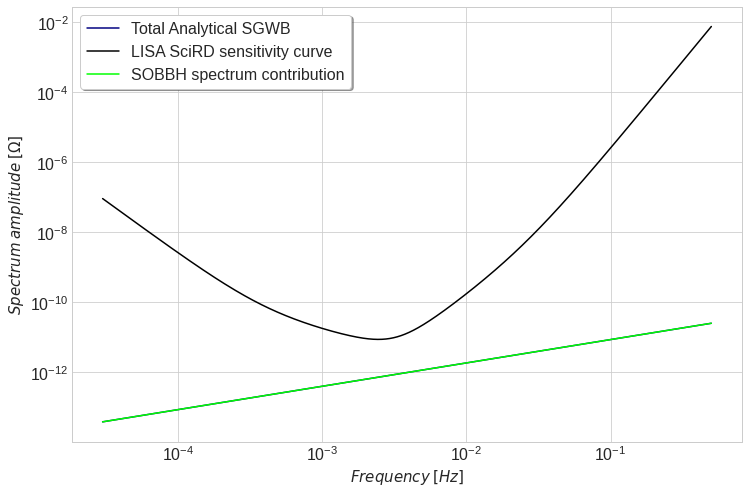

In [22]:
plt.figure(figsize=(12,8))
plt.loglog(ran_frq, spectrum, color = 'navy', label = 'Total Analytical SGWB')
plt.loglog(ran_frq, h_to_Omega(ran_frq,sensitivity), color  = 'black', label = 'LISA SciRD sensitivity curve')
if SOBBH:
    plt.loglog(ran_frq, hc_to_Omega(ran_frq, SOBBH_hcsqrd(ran_frq, SOBBH_IntFac)), color = 'lime', label = 'SOBBH spectrum contribution')
plt.xlabel('$Frequency \; [Hz]$', fontsize = 15 )
plt.legend(loc = 2, frameon = True, fancybox = True, shadow = True)
plt.ylabel('$Spectrum \; amplitude \; [\Omega]$', fontsize = 15)
plt.savefig('GeneratedSGWB.png',dpi=500)

<h2> Saving to an NPZ file </h2>

To conclude, in order to run with the SGWBinner, we need to save the generated data in an npz file,
let's start by defining an adapt name for the generated file :

In [23]:
# Defining the initial string name

d_name = 'AnalSGWB'

# Adding informations on the components included on the data

if SOBBH:
    d_name += 'wSOBBH'

we can now save the data with the simple command :

In [24]:
np.savez(d_name, signal_freq = ran_frq, signal_val = spectrum)
